In [1]:
from astropy import units as u
import numpy as np
import pylab as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

from astropy.stats import poisson_conf_interval as pci
from astropy.cosmology import LambdaCDM
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad
from tools.PCLuminosityFunction import LuminosityFunction
from tools.Briggs_OHLF import Briggs_OHLFVerification
import matplotlib.gridspec as gridspec




cosmos = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7) # Cosmology 


sns.set_style("whitegrid")


params = {'legend.fontsize': 12,
          'axes.labelsize': 15,
          'axes.titlesize': 15,
          'axes.linewidth': 0.5,
          'axes.edgecolor': '.15',
          'xtick.labelsize' :15,
          'ytick.labelsize': 15,
          'mathtext.fontset': 'cm',
          'mathtext.rm': 'serif',
          'mathtext.bf': 'serif:bold',
          'mathtext.sf': 'sans\\-serif',
         }
matplotlib.rcParams.update(params)
plt.rcParams["mathtext.default"] = "regular"

### SQL query code

SELECT field, help_id, ra, dec, redshift, f_spire_500, ferr_spire_500, cigale_dustlumin, cigale_dustlumin_err, f_pacs_green, ferr_pacs_green
FROM help_a_list.main 
WHERE field='NGP' AND f_spire_500 > 15000

##### TAP service link

https://herschel-vos.phys.sussex.ac.uk/__system__/tap/run/tap

# Analysing Data and Computing the OHLF from data


In [2]:
df = pd.read_csv('HELP_data/All_HELP_fields_spire500mircron_greater_15mJy.csv', index_col=[0])
df['logIRLum_solar'] = np.log10(((df['cigale_dustlumin'].values*u.W).to(u.L_sun)).value)
HELPdata = df.query('logIRLum_solar >=11 and zspec.notnull()', engine ='python') # removing None LIRGS and Nan entries

/var/folders/n_/j52ffk6j49j5z8f6m87mndq40000gn/T/ipykernel_19208/3170089585.py:2: RuntimeWarning: divide by zero encountered in log10
  df['logIRLum_solar'] = np.log10(((df['cigale_dustlumin'].values*u.W).to(u.L_sun)).value)


In [3]:
HELPdata.head()

,field,help_id,ra,dec,redshift,zspec,f_spire_500,ferr_spire_500,cigale_dustlumin,cigale_dustlumin_err,f_pacs_green,ferr_pacs_green,logIRLum_solar
188,ELAIS-N1,HELP_J162245.996+544311.255,245.691651,54.719793,0.5097,0.503763,22014.263,13045.737,2.015413e+38,1.007706e+37,17449.240,17186.530,11.721392
245,ELAIS-N1,HELP_J162147.779+543921.855,245.449079,54.656071,0.0690,0.054822,75500.690,5269.664,4.262730e+37,2.131365e+36,679868.200,20179.750,11.046716
323,ELAIS-N1,HELP_J162407.637+550438.666,246.031821,55.077407,1.3059,0.593768,24497.038,4366.221,2.196096e+38,1.098048e+37,11204.162,12382.480,11.758679
333,ELAIS-N1,HELP_J162351.566+551235.889,245.964858,55.209969,0.8101,2.537840,28143.394,6636.190,2.748301e+38,3.012867e+37,16455.025,15548.508,11.856092
429,ELAIS-N1,HELP_J162226.921+552941.867,245.612171,55.494963,0.6190,0.734044,22838.453,4542.591,3.320022e+38,1.660011e+37,28389.377,18566.650,11.938169


The figure below shows location of each OH candidate and their respective fields. 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mwd(RA, Dec, org=0, projection='mollweide'):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    '''
    # Convert RA and Dec to appropriate ranges
    x = np.remainder(RA + 360 - org, 360)
    ind = x > 180
    x[ind] -= 360
    x = -x

    # Define tick labels
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels + 360 + org, 360)

    # Create figure and axis
    fig = plt.figure(figsize=(20, 15))
    ax = fig.add_subplot(111, projection=projection)
    
    # Scatter plot with seaborn
    sns.scatterplot(data=HELPdata, x=np.radians(x), y=np.radians(Dec), hue="field", 
                    marker='o', linewidth=0, alpha=0.7, legend=False, ax=ax)

    # Set axis labels and grid
    ax.set_xticklabels(tick_labels, fontsize=12)
    ax.set_xlabel("RA", fontsize=14, fontweight='bold')
    ax.set_ylabel("Dec", fontsize=14, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.5)

    # Define field coordinates and names
    fields = ['ELAIS-N1', 'XMM-13hr', 'SA13', 'CDFS-SWIRE', 'GAMA-12', 'GAMA-09', 'XMM-LSS',
              'GAMA-15', 'SSDF', 'HDF-N', 'COSMOS', 'Herschel-Stripe-82', 'SPIRE-NEP', 'AKARI-SEP',
              'xFLS', 'NGP', 'ELAIS-S1', 'ELAIS-N2', 'AKARI-NEP', 'EGS']
    fields_coords = [(242.9, 55.071), (203.6, 37.918), (198.0, 42.715), (53.1, -28.235), (179.8, -0.482), (134.7, 0.513),
                     (35.1, -4.528), (217.6, 0.456), (351.9, -55.114), (189.2, 62.241), (150.1, 2.218), (14.3, -0.034),
                     (265.0, 69.004), (70.8, -53.862), (259.0, 59.384), (199.5, 29.215), (8.8, -43.585), (249.2, 41.058),
                     (270.0, 66.556), (215.0, 52.720)]

    # Convert field coordinates
    xx = np.array(fields_coords)
    ra = xx[:, 0]
    dec = xx[:, 1]
    x_ = np.remainder(ra + 360 - org, 360)
    ind_ = x_ > 180
    x_[ind_] -= 360
    x_ = -x_

    # Annotate fields on the plot
    for i in range(len(fields)):
        ax.annotate(fields[i], (np.radians(x_[i]), np.radians(dec[i])),
                    horizontalalignment='center', verticalalignment='center',
                    fontsize=12, color='black')

    # Save the plot
    plt.savefig('ThisWork_ra_dec.png', dpi=400, bbox_inches='tight')

    # Show plot
    plt.show()


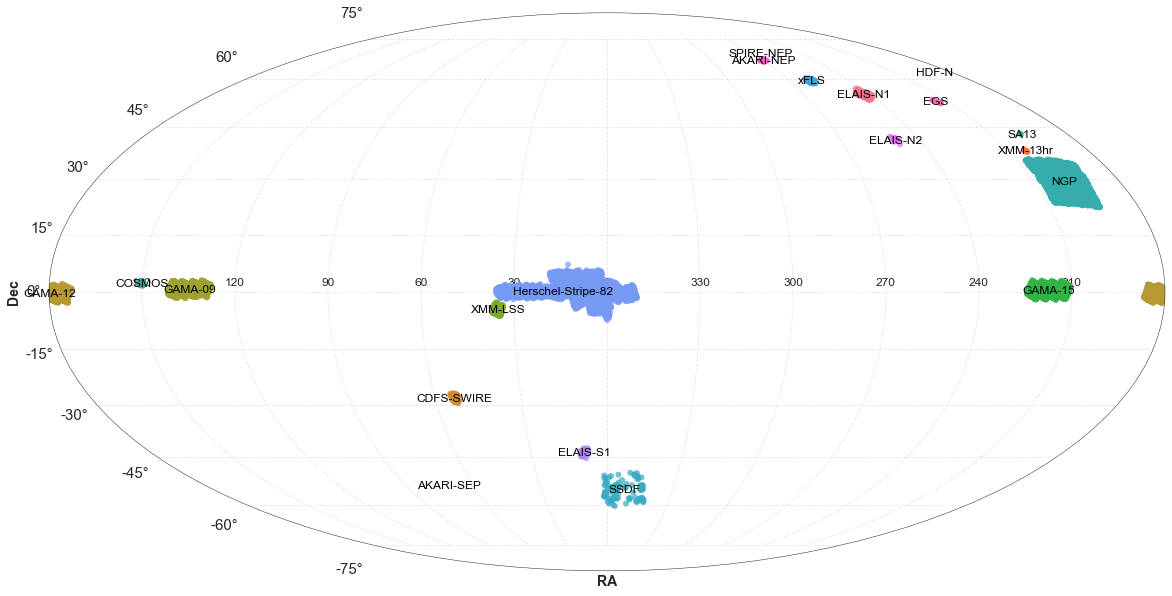

In [5]:
plot_mwd(HELPdata['ra'],HELPdata['dec'],org=0, projection='mollweide')

-----

#### Converting the dust infrared luminosity (L$_{IR}$) from the HELP data modelled using a CIGALE code to OH-Luminosity using the OH and FIR luminosity correlation derived by Darling & Giovanelli (2002a) for an Arecibo survey plus literature sample of OHMs, i.e., 
#### log (L$_{OH}$ /L⊙ ) = (1.57 ± 0.11) log (L$_{FIR}$ /L⊙ ) − (15.76 ± 1.22) Glowacki, M. et.al (2022) (https://arxiv.org/pdf/2204.02523.pdf)

In [6]:
# converting IR Luminosity to OH-Luminosity using the OH-FIR luminosity correlation 
HELPdata['logOHLum_solar'] =  1.58*(HELPdata['logIRLum_solar'].values) - 15.93


/var/folders/n_/j52ffk6j49j5z8f6m87mndq40000gn/T/ipykernel_19208/2617674886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HELPdata['logOHLum_solar'] =  1.58*(HELPdata['logIRLum_solar'].values) - 15.93


/var/folders/n_/j52ffk6j49j5z8f6m87mndq40000gn/T/ipykernel_19208/903069970.py:38: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  axHistx.set_ylim(0, max(axHistx.get_ylim()) * 1.1)
/var/folders/n_/j52ffk6j49j5z8f6m87mndq40000gn/T/ipykernel_19208/903069970.py:39: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  axHisty.set_xlim(0, max(axHisty.get_xlim()) * 1.1)


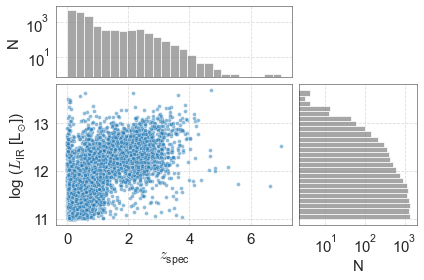

In [18]:
# Create a figure and scatter plot
fig, axScatter = plt.subplots()

# Scatter plot
scatter = axScatter.scatter(HELPdata['zspec'], HELPdata['logIRLum_solar'], s=15, alpha=0.5, edgecolor='w', linewidth=0.5)
axScatter.set_xlabel('$\mathit{z}_{spec}$')
axScatter.set_ylabel(r'log ($\mathit{L}_{IR}$ [L$_{\odot}])$')
axScatter.grid(True, linestyle='--', alpha=0.7)

# Create new axes on the right and on the top of the current axes
divider = make_axes_locatable(axScatter)
axHistx = divider.append_axes("top", size="50%", pad=0.1, sharex=axScatter)
axHisty = divider.append_axes("right", size="50%", pad=0.1, sharey=axScatter)

# Plot histograms
axHistx.hist(HELPdata['zspec'], bins=25, color='gray', alpha=0.7)
axHistx.set_yscale('log')
axHistx.set_ylabel('N')

axHisty.hist(HELPdata['logIRLum_solar'], bins=25, orientation='horizontal', color='gray', alpha=0.7)
axHisty.set_xscale('log')
axHisty.set_xlabel('N')

# Hide x labels and tick labels for the top plot
plt.setp(axHistx.get_xticklabels(), visible=False)
plt.setp(axHistx.get_xticklines(), visible=False)

# Hide y labels and tick labels for the right plot
plt.setp(axHisty.get_yticklabels(), visible=False)
plt.setp(axHisty.get_yticklines(), visible=False)


# Add grid to histograms
axHistx.grid(True, linestyle='--', alpha=0.7)
axHisty.grid(True, linestyle='--', alpha=0.7)

# Set limits for histograms
axHistx.set_ylim(0, max(axHistx.get_ylim()) * 1.1)
axHisty.set_xlim(0, max(axHisty.get_xlim()) * 1.1)

# Adjust layout
plt.tight_layout()

# Show plot
plt.savefig('ThisWork_redshift_Luminosity_distributions.png', dpi=400, bbox_inches='tight')


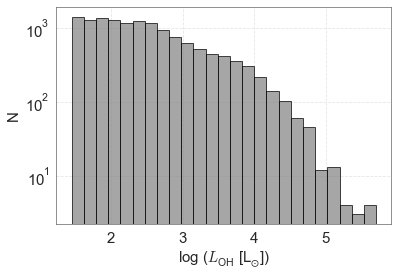

In [19]:
plt.figure()
plt.hist(HELPdata['logOHLum_solar'], bins=25, color='gray', edgecolor='black', alpha=0.7)
plt.xlabel(r'log ($\mathit{L}_{OH}$ [L$_{\odot}])$')
plt.ylabel('N')
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('ThisWork_OHLuminosity_distributions.png', dpi=400, bbox_inches='tight')


In [20]:
HELPdata.to_csv('All_HELP_fields_spire500mircron_greater_15mJy_ULIRGs.csv', index = False)

###  This Work's OH Luminosity function using Page & Carrera's method

In [21]:
OHLF = LuminosityFunction(HELPdata_Lum_masked['logOHLum_solar'].values, HELPdata_Lum_masked['redshift'].values, 
                          zbin = [HELPdata_Lum_masked['redshift'].min(),HELPdata_Lum_masked['redshift'].max()],
                          step=0.5, AreaCoverage=940.7,AreaCoverage_units='sqdeg') 

Lumbins_centre, LumFunbins_mean, stdbins, NoLumperbin = OHLF.luminosityfunction()

# Fitting a Power-Law to the luminosity function:
def OHLF_model(m, x, c):
    return m*x + c
initial_guess = (-0.64, np.log10(9.8e-6))
popt,pcov = curve_fit(f = OHLF_model, xdata = Lumbins_centre ,ydata = LumFunbins_mean, p0=initial_guess)




print(popt, np.sqrt(np.diag(pcov)))



plt.plot(Lumbins_centre,LumFunbins_mean,color='orange', marker='.',ls = '', label='Data')
plt.errorbar(x=Lumbins_centre,y=LumFunbins_mean, yerr=stdbins,fmt='None',ecolor='black',alpha=0.5, 
             lw= 1, capsize=3, capthick=2)

plt.plot(Lumbins_centre,OHLF_model(popt[0], Lumbins_centre, popt[1]),'--', 
         c='tab:red', label = 'Power-Law fit', linewidth=1.5, alpha =1)
plt.xlabel(r'log (L$_{OH}$ [L$_{\odot}])$')
plt.ylabel('log ($\Phi$ [Mpc$^{-3}$ $\Delta$ log L$_{OH}$$^{-1}])$')
plt.legend(loc='upper right')
plt.savefig('ThisWork_OHLF.png', dpi=400, bbox_inches='tight')

NameError: name 'HELPdata_Lum_masked' is not defined

## The power-law fit yields log $\Phi$ = (-0.77 $\pm$ 0.12)log L$_{OH}$ - (3.76 $\pm$ 0.51)

# Differentiating between LIRGs, ULIRGs and HyLIRGs:

* LIRG: Luminous Infrared Galaxy

    LIRGs are defined as having 8-1000 µm luminosities between 10$^{11}$ L⊙ and 10$^{12}$ L⊙ .
    

* ULIRG: Ultraluminous Infrared Galaxy

    ULIRGs are defined as having 8-1000 µm luminosities between 10$^{12}$ L⊙ and 10$^{13}$ L⊙ .


* HyLIRG: Hyperluminous Infrared Galaxy

    HyLIRGs are defined as having 8-1000 µm luminosities between 10$^{13}$ L⊙ and 10$^{14}$ L⊙ .


In [12]:
HELPdata_LIRGS_masked = HELPdata_Lum_masked.query('11 < logIRLum_solar < 12')

In [13]:
# redshift 0.1 < z < 0.23 Luminosity function

HELPdata_redshift_masked = HELPdata_Lum_masked.query('0.1 < redshift < 0.23')

OHLF_z_masked = LuminosityFunction(HELPdata_redshift_masked['logOHLum_solar'].values,
                           HELPdata_redshift_masked['redshift'].values,
                           zbin = [0.1,0.23],
                           step=0.5, AreaCoverage=940.7,AreaCoverage_units='sqdeg')
Lumbins_centre_z_masked, LumFunbins_mean_z_masked, stdbins_z_masked, NoLumperbin_z_masked = OHLF_z_masked.luminosityfunction()


# LIRGS Luminosity function
HELPdata_LIRGS_masked = HELPdata_Lum_masked.query('11 < logIRLum_solar < 12')
OHLF_LIRGS = LuminosityFunction(HELPdata_LIRGS_masked['logOHLum_solar'].values,
                           HELPdata_LIRGS_masked['redshift'].values,
                           zbin = [HELPdata_LIRGS_masked['redshift'].min(),HELPdata_LIRGS_masked['redshift'].max()],
                           step=0.5, AreaCoverage=940.7,AreaCoverage_units='sqdeg') 
Lumbins_centre_LIRGS, LumFunbins_mean_LIRGS, stdbins_LIRGS, NoLumperbin_LIRGS = OHLF_LIRGS.luminosityfunction()


# ULIRGS Luminosity function
HELPdata_ULIRGS_masked = HELPdata_Lum_masked.query('12 < logIRLum_solar < 13')
OHLF_ULIRGS = LuminosityFunction(HELPdata_ULIRGS_masked['logOHLum_solar'].values,
                           HELPdata_ULIRGS_masked['redshift'].values,
                           zbin = [HELPdata_ULIRGS_masked['redshift'].min(),HELPdata_ULIRGS_masked['redshift'].max()],
                           step=0.5, AreaCoverage=940.7,AreaCoverage_units='sqdeg')  
Lumbins_centre_ULIRGS, LumFunbins_mean_ULIRGS, stdbins_ULIRGS, NoLumperbin_ULIRGS = OHLF_ULIRGS.luminosityfunction()




# Briggs FIR Luminosity function

In [14]:
OHLumBriggs = np.linspace(10, 10**6.5, 100)

Briggs_OHLF = Briggs_OHLFVerification(OHLumBriggs, fm =  1)

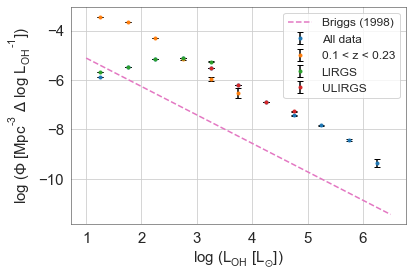

In [15]:
plt.figure()

plt.plot(np.log10(OHLumBriggs), np.log10(Briggs_OHLF.value)
         , label='Briggs (1998)', color='tab:pink', linestyle='dashed')


plt.errorbar(x=Lumbins_centre,y=LumFunbins_mean, yerr=stdbins, label='All data',
             ecolor='k', fmt='.', capsize=3)


plt.errorbar(x=Lumbins_centre_z_masked,y=LumFunbins_mean_z_masked, yerr=stdbins_z_masked,
             label='0.1 < z < 0.23', fmt=".",  capsize=3,  ecolor="k")

plt.errorbar(x=Lumbins_centre_LIRGS,y=LumFunbins_mean_LIRGS, yerr=stdbins_LIRGS, label='LIRGS',
             fmt=".",  capsize=3,  ecolor="k")

plt.errorbar(x=Lumbins_centre_ULIRGS,y=LumFunbins_mean_ULIRGS, yerr=stdbins_ULIRGS, label='ULIRGS',
             fmt=".",  capsize=3,  ecolor="k")

plt.xlabel('log (L$_{OH}$ [$L_{\odot}])$')
plt.ylabel('log ($\Phi$ [Mpc$^{-3}$ $\Delta$ log L$_{OH}$$^{-1}])$')
plt.legend(loc='upper right',fontsize = 'large')
plt.savefig('ThisWork_OHLF_comparison.png', dpi = 400,  bbox_inches='tight')